# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [15]:
import neuro_op as nop

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st


In [56]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=11),   # networkx graph object
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Likelihood function (llf) parameters of nodes, Gaussian by default
        loc=1,
        scale=1,
    ),
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=1,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=20,  # End time of simulation
    t_sample=1,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=41,  # Number of bins used in distance measures
    sample_range=(-10, 10),  # Interval over which distance measure distributions are considered
    p_distance_params=[(1, 1), (2, 1)],  # List of tuples, each containing two floats, defining the p-distance parameters
    progress=False,  # Whether or not to print sampling times
)

In [57]:
out1 = nop.run_model_Laplace(**input)

print(out1['N_events'])

3973


## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [58]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [59]:
for i in out1.keys():
    print(i)

nodes
G
world
N_events
t_end
mu_nodes
kl_divs
p_distances
seed



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

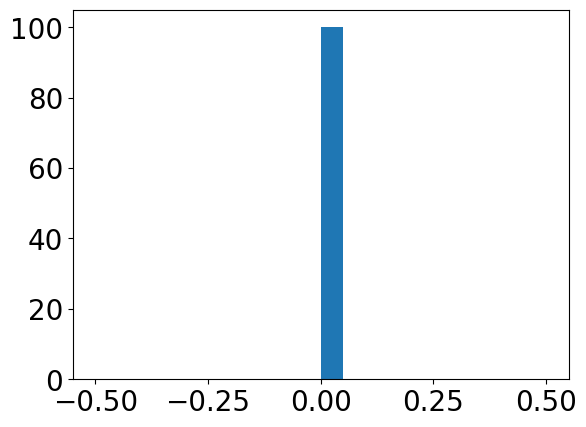

In [60]:
sigmas = []
for i in out1['nodes']:
    sigmas += [i.params_node['scale']]
plt.hist(sigmas, bins=20)

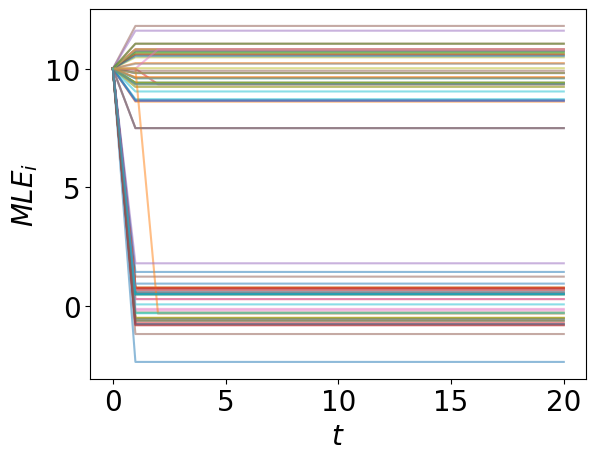

In [61]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
for i in range(len(mu_arr.T)):
    plt.plot(x, mu_arr.T[i], alpha=0.5, label=f"Node {i}")
    plt.xlabel("$t$")
    plt.ylabel("$MLE_i$")

#### Data analysis 2

In [22]:
N_iter = range(input["G"].number_of_nodes())
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
quad_dis = np.array(out1["p_distances"])[:, 1]
print(lin_dis.shape)
kld.shape
np.array(out1["p_distances"]).shape

(21, 100)


(21, 2, 100)

(21,)

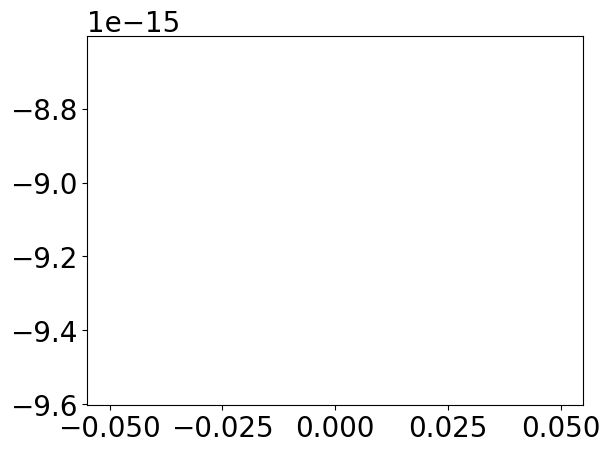

In [23]:
#for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])


i = 1
plt.plot(
    #input["t_sample"] * np.arange(0, kld.shape[0]),
    kld.mean(axis=i),
    label="avg"
    )
kld.mean(axis=i).shape

In [24]:
for i in N_iter:
    plt.plot(input["t_sample"] * np.arange(0, quad_dis.shape[0]), quad_dis[:, 0, i])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

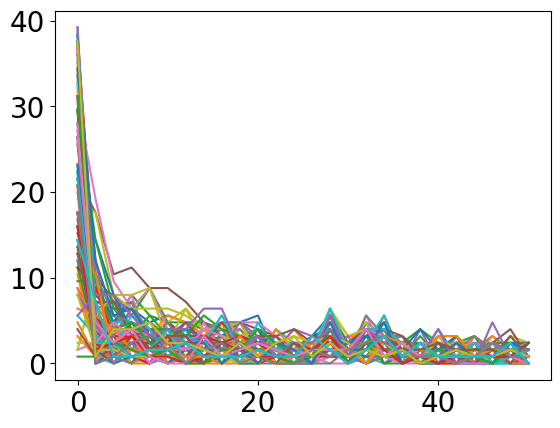

In [ ]:
for i in N_iter:
    plt.plot(input["t_sample"] * np.arange(0, lin_dis.shape[0]), lin_dis[:, 0, i])

In [ ]:
arr = np.array(out1["p_distances"])
print(arr.shape)
(arr[-1, 0, 1, :] ** 2).mean()

(26, 2, 2, 100)


2.8095999999999997

In [ ]:
arr2 = np.array(out1["kl_divs"])
arr2.shape
np.array(out1["mu_nodes"]).shape

(26, 100)

In [ ]:
arr[:, 0].shape

(26, 2, 100)